In [1]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=1,
                       memory ='180GB',
                       walltime="12:00:00")

In [2]:
# Call at head node, otherwise you won't get the dashboard
from dask.distributed import Client
cluster.scale(1) # number of nodes you request
client = Client(cluster)
client

Client Scheduler: tcp://128.104.200.53:44735 Dashboard: http://128.104.200.53:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
import time
import SeqIO
from SeqIO.CeleritasSeqReader import SeqReader
from SeqIO.utils.file_utils import read_ref
from tqdm.notebook import tqdm, trange
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import glob,os
import math
import sys
import hyperspy.api as hs
from hyperspy import io_plugins
from scipy import ndimage

In [32]:
%matplotlib notebook

In [1]:
def map8bit(data):
      return ((data - data.min())/(data.max() - data.min())*255).astype('int8')

def findcom(data):
    if data.ndim<4:
        data = data[np.newaxis,np.newaxis, :,:]
    kx, ky = data.shape[2:]
    kx = np.linspace(0,kx-1,kx)
    ky = np.linspace(0,ky-1,ky)
    weights_x, weights_y = np.meshgrid(kx,ky)

    COM = np.zeros((data.shape[0],data.shape[1],2))
    
    for irow in range(data.shape[0]):
        for icol in range(data.shape[1]):
            sample = data[irow, icol, :,:]
            COM[irow,icol,0] = np.average(weights_x,weights = sample)
            COM[irow,icol,1] = np.average(weights_y,weights = sample)

    return COM.squeeze()

def houghcenter(sample, thres, radiimin, radiimax):
    
    bw = 1.0*(sample > thres)
    selem = disk(3)
    bw2 = closing(bw, selem)
    edges = feature.canny(bw2)

    sample = sample.astype('uint8')
    temp = edges.astype('uint8')

    image = sample

    # Detect two radii
    hough_radii = np.arange(radiimin,radiimax,1)
    hough_res = hough_circle(temp, hough_radii)

    # Select the most prominent 5 circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=3)
    try:
        cx = int(np.average(cx))
        cy = int(np.average(cy))
        radii = int(np.average(radii))
        
    except:
        cx = None
        cy = None

    #print('cx axis1:', cx,'cy axis2:',cy,'radius:',radii)
    #if cx == None or cy == None:
    #print('None')
    
    return cx, cy 


def enhance_contrast(image_matrix, bins=256):
    image_flattened = image_matrix.flatten()
    image_hist = np.zeros(bins)

    # frequency count of each pixel
    for pix in image_flattened:
        image_hist[pix] += 1

    # cummulative sum
    cum_sum = np.cumsum(image_hist)
    norm = (cum_sum - cum_sum.min()) * 255
    # normalization of the pixel values
    n_ = cum_sum.max() - cum_sum.min()
    uniform_norm = norm / n_
    uniform_norm = uniform_norm.astype('int')

    # flat histogram
    image_eq = uniform_norm[image_flattened]
    # reshaping the flattened matrix to its original shape
    image_eq = np.reshape(a=image_eq, newshape=image_matrix.shape)

    return image_eq

def Reconstruction(signal_slice, cx, cy, BF_radius, withADF, thres):
    
    signal_slice.data[signal_slice.data<thres] = 0
    rx,ry,kx,ky = signal_slice.data.shape
    PACBED = np.zeros((kx,ky))
    #COM = np.load('/srv/home/jwei74/4DSTEMdata/CeleritasTest/20210621/86000fpsA30um/BlankCOM.npy')##############

    kx = np.linspace(0,kx-1,kx)
    ky = np.linspace(0,ky-1,ky)
    kx2,ky2 = np.meshgrid(kx,ky)## swaped

    COM_exp = np.zeros((rx,ry,2))
    COM_exp_ang = np.zeros((rx,ry))
    BF = np.zeros((rx,ry))
    ABF = np.zeros((rx,ry))
    eBF = np.zeros((rx,ry))
    ADF = np.zeros((rx,ry))

    ABF_radius = BF_radius/2
    ADF_radius = BF_radius*1.36

    for ix in range(rx):
        for iy in range(ry):

            frame = signal_slice.data[ix,iy,:,:]

            #cx = COM[ix,iy,0]
            #cy = COM[ix,iy,1]

            distance_from_center = np.sqrt((kx2 - cx)**2 + (ky2-cy)**2)
            ADF_mask = (distance_from_center > (BF_radius)) & (distance_from_center <= (ADF_radius))
            ABF_mask = (ABF_radius <= distance_from_center) & (distance_from_center <= BF_radius)
            BF_mask = distance_from_center <= BF_radius
            lBF_mask = distance_from_center <= ABF_radius

            res = ndimage.measurements.center_of_mass(signal_slice.data[ix,iy,:,:]*BF_mask)
            COM_exp[ix,iy,0] = res[0]-cx
            COM_exp[ix,iy,1] = res[1]-cy        
            BF[ix,iy] = (frame*BF_mask).sum()
            ABF[ix,iy] = (frame*ABF_mask).sum()
            ADF[ix,iy] = (frame*ADF_mask).sum() if withADF else None
            eBF[ix,iy] = ABF[ix,iy]-(frame*lBF_mask).sum()
            PACBED = PACBED + frame
    
    return COM_exp, BF, ABF, eBF, PACBED, ADF

In [123]:
chunk = (128,128)
nav=(512,512)
radius = (0, 61) # 19 for CL150, 61 for CL410
folder = '/srv/home/jwei74/Ptychography/20211115/movie389/'
signal = SeqIO.load_folder(folder,lazy=True, chunk_shape=chunk, nav_shape=nav)
signal.data

dask.array<get_image_chunk, shape=(512, 512, 128, 256), dtype=float32, chunksize=(128, 128, 128, 256), chunktype=numpy.ndarray>

### Check satuation and drift

Satuation: 11 e/px 

4091


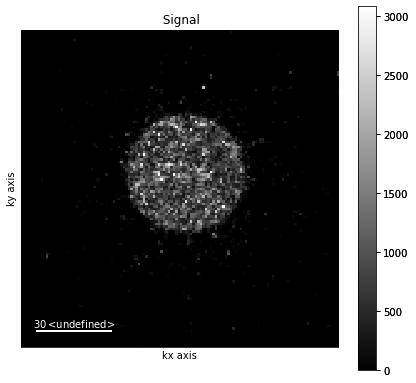

In [124]:
frame = signal.inav[255,255].isig[64:-64,:]
frame.compute()
frame.plot()
print(frame.data.max())


Using detecting-hough-center method to get the position of the zero beam and generates the shifts for center the whole dateset.  

In [129]:
frameseries = signal.isig[64:-64,:]
frameseries.compute()

center = np.zeros((512,512,2))

for irow in range(512):
    for icol in range(512):
        img = frameseries.data[irow, icol, :,:]
        center[irow,icol] = np.squeeze(houghcenter(img, 800, 23,25))
    if irow % 10 == 0:
        print('Finish row', irow) 

/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Finish row 0
Finish row 10
Finish row 20
Finish row 30
Finish row 40
Finish row 50
Finish row 60
Finish row 70
Finish row 80
Finish row 90
Finish row 100
Finish row 110
Finish row 120
Finish row 130
Finish row 140
Finish row 150
Finish row 160
Finish row 170
Finish row 180
Finish row 190
Finish row 200
Finish row 210
Finish row 220
Finish row 230
Finish row 240
Finish row 250
Finish row 260
Finish row 270
Finish row 280
Finish row 290
Finish row 300
Finish row 310
Finish row 320
Finish row 330
Finish row 340
Finish row 350
Finish row 360
Finish row 370
Finish row 380
Finish row 390
Finish row 400
Finish row 410
Finish row 420
Finish row 430
Finish row 440
Finish row 450
Finish row 460
Finish row 470
Finish row 480
Finish row 490
Finish row 500
Finish row 510


In [130]:
np.save('/srv/home/jwei74/Ptychography/20211115/movie389/houghcenter.npy', center)

In [131]:
centers = np.load('/srv/home/jwei74/Ptychography/20211115/movie389/houghcenter.npy')
centers[0,0,0] = 65 # set the nan to be zero shift
centers[0,0,0] = 65
shift_x = centers[:,:,0]-65
shift_y = centers[:,:,1]-65

frameseries.set_signal_type('electron_diffraction')

#frame.center_direct_beam(shifts=s_shifts,return_shifts=Ture,subpixel=True,)

In [132]:
# shift value = data center - desinated center
signal_reg = frameseries.shift_diffraction(shift_x = shift_x,shift_y = shift_y,interpolation_order=1,
                                          parallel=True,inplace=False,show_progressbar=True)

  0%|          | 0/262144 [00:00<?, ?it/s]

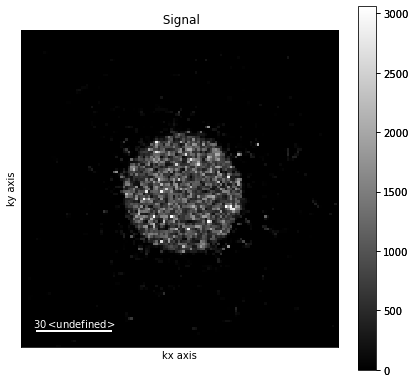

In [135]:
signal_reg.inav[15,10].plot()

In [136]:
COM_exp, BF, ABF, eBF, PACBED, ADF = Reconstruction(signal_reg, 65, 65, 23, True, 7)

/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


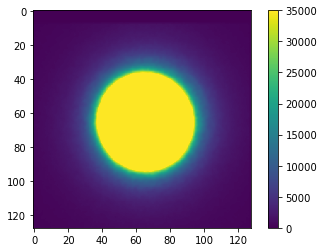

In [149]:
COM_exp_mag = np.sqrt(COM_exp[:,:,0]**2 + COM_exp[:,:,1]**2)
plt.imshow(PACBED/241, vmax = 35000 )
plt.colorbar()

(-0.5, 511.5, 511.5, -0.5)

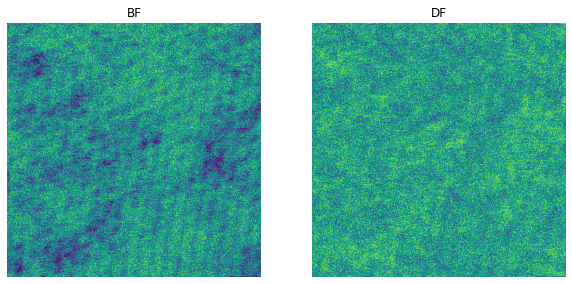

In [144]:
fig = plt.figure(figsize = (10,10))
plt.subplot(121)
#plt.imshow(np.log(BF/241), vmax = 9)
plt.imshow(enhance_contrast(map8bit(BF)),vmax = 300)
plt.title('BF')
plt.axis('off')

plt.subplot(122)
#plt.imshow(np.log(ADF/241), vmax = 7)
plt.imshow(enhance_contrast(map8bit(ADF)),vmax = 300)
plt.title('DF')
plt.axis('off')

In [150]:
savepath = '/srv/home/jwei74/Ptychography/20211115/movie389/'

np.save(savepath+'ADF.npy',ADF)
np.save(savepath+'BF.npy',BF)
np.save(savepath+'PACBED.npy',PACBED)

### Check counting

1 shows pixels that are sparse enough, 0 shows the opposite

It looks sp11 with CL 410, 49000Hz doesn't meet the requirement

Text(0.5, 1.0, 'Single Frame')

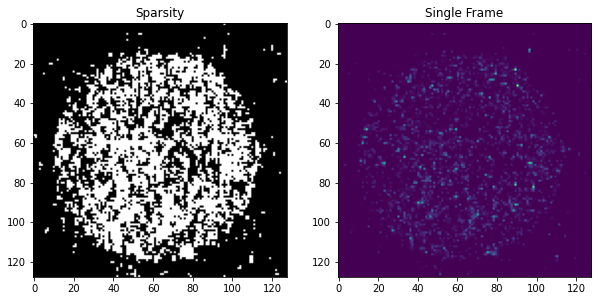

In [36]:
m = signal.data[20,10,:,:]
#signal.data[signal.data<7] = 0
#m = signal.sum().data
c = m/266*2.5
result = c
for index,value in np.ndenumerate(result):
    if value > 0.05:
        result[index] = 1
    else:
        result[index] = 0
fig = plt.figure(figsize = (10,10))
plt.subplot(121)
a = plt.imshow(result, cmap = 'gray')
plt.title('Sparsity')
#plt.colorbar(a, shrink = 0.4)
plt.subplot(122)
b = plt.imshow(m)
plt.title('Single Frame')
#plt.colorbar(b, shrink = 0.4)

### Make a mat file for a dataset

In [151]:
data = {}
data['alpha_max'] = np.asarray([[23.4]])

In [152]:
data['crop_idx'] = np.asarray([[]])
data['df'] = np.asarray([[0]])
data['cs'] = np.asarray([[0]])

In [153]:
# reciprocal space pixel size (inverse angstrom)
data['dk'] = np.asarray([[0.11316]]) # CL 195
#data['dk'] = np.asarray([[0.0538]]) # CL 410

In [160]:
signal_reg

<ElectronDiffraction2D, title: , dimensions: (512, 512|128, 128)>

In [161]:
data['dp'] = np.flip(signal_reg.data[300:428,300:428,:,:], axis = 2) # DP vertically flipped!!!!
data['dp'] = np.moveaxis(data['dp'], [0, 1], [2, 3])
data['dp'].shape

(128, 128, 128, 128)

In [155]:
data['lambda'] = np.asarray([[0.02508]])

In [159]:
data['scanStepSize_x'] = np.asarray([[0.1]])
data['scanStepSize_y'] = np.asarray([[0.1]])

In [157]:
data['voltage'] = np.asarray([[200]])

515x512 scan grid data shows error: Matrix too large to save with Matlab 5 format

In [162]:
# need '-v7' to avoid loading error for big size data
scipy.io.savemat('/srv/home/jwei74/Ptychography/20211115/movie389/WS2_movie389_scan300_428.mat',data ,'-v7')

#sio.savemat('/srv/home/jwei74/Ptychography/20210816/movie131/WS2_movie131_081621.mat',data)

### Backup

[########################################] | 100% Completed | 30.2s


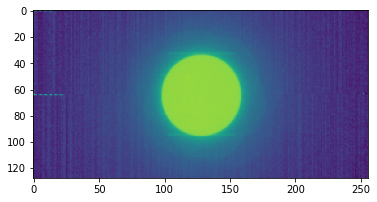

In [72]:
from SeqIO import load_folder
signal = load_folder('/srv/home/voyles/Jingrui/Data/OurData/',lazy=True, chunk_shape=(128,128), nav_shape=(257,256))

signal.set_signal_type('electron_diffraction')
#signal.crop('kx', start=croph[0], end=croph[1])
#signal.crop('ky', start=cropv[0], end=cropv[1])
signal.compute()
a = signal.sum()
plt.imshow(np.log(1+a.data))

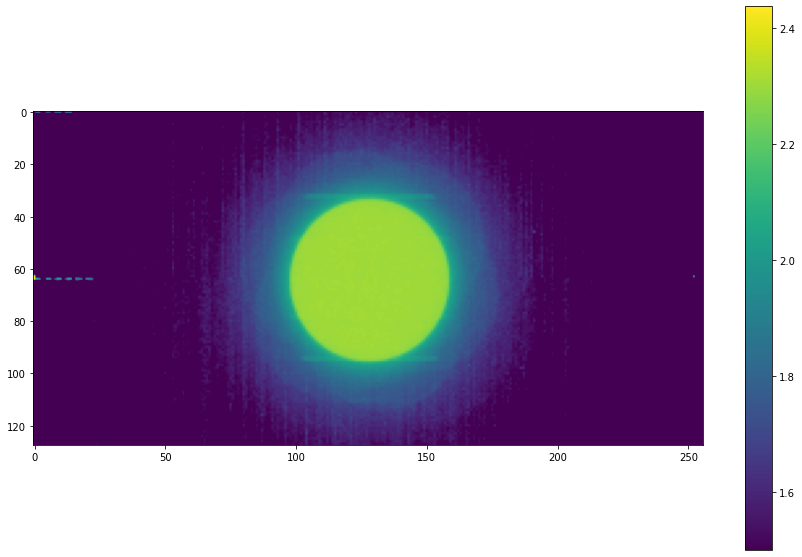

In [154]:
fig = plt.figure(figsize = (15,10))
plt.imshow(np.log(4+np.log(a.data/257/256)), vmin = 1.5)
plt.colorbar()

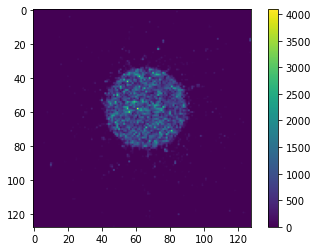

In [125]:
sample = frame.data
plt.imshow(sample)
plt.colorbar()

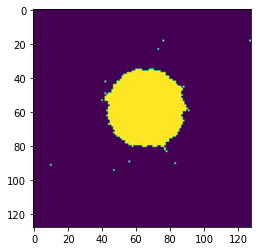

In [126]:
from skimage import feature
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.morphology import disk
from skimage.morphology import closing
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
bw = 1.0*(sample > 800)
plt.imshow(bw)
selem = disk(3)
bw2 = closing(bw, selem)
plt.imshow(bw2)
edges = feature.canny(bw2)

[66 67 65] [58 58 59] [23 24 24]
66 58 23


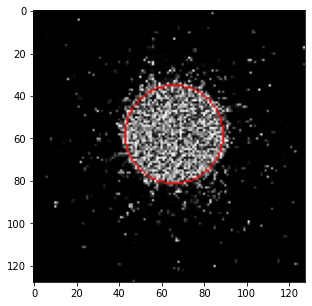

cx axis1: 66 cy axis2: 58 radius: 23


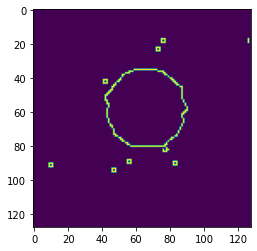

In [127]:
sample = frame.data
bw = 1.0*(sample > 800)
selem = disk(3)
bw2 = closing(bw, selem)
edges = feature.canny(bw2)

sample = sample.astype('uint8')
temp = edges.astype('uint8')

image = sample

# Detect two radii
hough_radii = np.arange(20,25,1)
hough_res = hough_circle(temp, hough_radii)

# Select the most prominent 5 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=3)

print(cx,cy,radii)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
image = color.gray2rgb(image)
cx = int(np.average(cx))
cy = int(np.average(cy))
radii = int(np.average(radii))

print(cx,cy,radii)
circy, circx = circle_perimeter(cy,cx,radii)

image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()
plt.imshow(temp)
print('cx axis1:', cx,'cy axis2:',cy,'radius:',radii)

In [29]:
def houghcenter(sample, thres, radiimin, radiimax):
    
    bw = 1.0*(sample > thres)
    selem = disk(3)
    bw2 = closing(bw, selem)
    edges = feature.canny(bw2)

    sample = sample.astype('uint8')
    temp = edges.astype('uint8')

    image = sample

    # Detect two radii
    hough_radii = np.arange(radiimin,radiimax,1)
    hough_res = hough_circle(temp, hough_radii)

    # Select the most prominent 5 circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=3)
    try:
        cx = int(np.average(cx))
        cy = int(np.average(cy))
        radii = int(np.average(radii))
        
    except:
        cx = None
        cy = None

    #print('cx axis1:', cx,'cy axis2:',cy,'radius:',radii)
    #if cx == None or cy == None:
    #print('None')
    
    return cx, cy 


In [ ]:
# Check crop and background
croph = (64,192) # axis1
cropv = (0,128) # axis0
signal.set_signal_type('electron_diffraction')
signal.crop('kx', start=croph[0], end=croph[1])
signal.crop('ky', start=cropv[0], end=cropv[1])

#signal.center_direct_beam(method='cross_correlate') # doesnt work for this CBED
#signal.set_diffraction_calibration(0.00208*4) # for 256x256chip
signal.data[signal.data<7] = 0 # threshold
signal = signal/241 # integration
signal.compute()